In [1]:
import glob
import os
import random
import shutil
import sys
from pathlib import Path

import numpy as np
import scipy.io
import torch

current_dir = os.path.dirname(os.path.abspath("__file__"))  # 当前目录
parent_dir = os.path.abspath(os.path.join(current_dir, ".."))  # 上一级目录
sys.path.append(parent_dir)
grandparent_dir = os.path.abspath(os.path.join(parent_dir, ".."))  # 上两级目录
sys.path.append(grandparent_dir)

import data_function
import metrics
import network
import tools
import utils

# from test_case.ex_main.model import *
# from test_case.ex_main.train_dataloader import getData
from ex_main1.model import *
from ex_main1.train_dataloader import getData
from utils.config_plot import *

In [2]:
ppath = "/home/hy/project/reid_task/ex_main1"

# Config
config_file_path = os.path.join(ppath, "config.py")
config = utils.common.read_config_file(config_file_path)

# Initialize a logger tool
logger = utils.logger.Logger(config.outputs_path)
logger.info("#" * 50)
logger.info(f"Task: {config.taskname}")
logger.info(f"Using device: {config.device}")
logger.info(f"Using data type: {config.dtype}")

# Set environment
random.seed(config.seed)
np.random.seed(config.seed)
torch.manual_seed(config.seed)
torch.cuda.manual_seed(config.seed)
torch.cuda.manual_seed_all(config.seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False  # The result cannot be reproduced when True

vis_outputs_path = "./results/vis/"
if os.path.exists(vis_outputs_path):
    shutil.rmtree(vis_outputs_path)

2024-06-14 20:16:33 INFO ##################################################
2024-06-14 20:16:33 INFO Task: ReID_Task
2024-06-14 20:16:33 INFO Using device: cuda
2024-06-14 20:16:33 INFO Using data type: torch.float32


In [3]:
def cosine_interpolation_node_selection(n):
    x = torch.zeros(n, 1)
    for i in range(n):
        x[i] = 1 / 2 * (1 - np.cos(i * torch.pi / (n - 1)))
    return x


def derivative_coefficient_of_Lagrange_interpolation(x):
    n = x.shape[0]
    A1 = torch.zeros(n, n)
    for i in range(n):
        for j in range(n):
            if i == j:
                a = 0
                for k in range(n):
                    if k != j:
                        a = a + 1 / (x[j] - x[k])
                A1[i, j] = a
            else:
                a = 1
                for k in range(n):
                    if k != j:
                        a = a * 1 / (x[j] - x[k])
                        if k != i:
                            a = a * (x[i] - x[k])
                A1[i, j] = a
    return A1

In [4]:
def newton_iteration_method(u0, G_func, u0_0, ut0_0, esp=1e-4, max_iteration=100):
    current_iteration = 0
    uk = u0
    while True:
        G = torch.func.vmap(G_func, in_dims=(0, 0, 0))(uk, u0_0, ut0_0)
        Gu_func = torch.func.vmap(
            torch.func.jacrev(G_func, argnums=0), in_dims=(0, 0, 0)
        )
        Gu = Gu_func(uk, u0_0, ut0_0).squeeze()
        uk_next = uk - torch.einsum("bij,bj->bi", torch.linalg.inv(Gu), G)
        if current_iteration > max_iteration:
            break
        if torch.norm(uk_next - uk) < esp:
            return uk_next
        current_iteration += 1
        uk = uk_next
    return uk


g = 9.8
l = 10
num_nodes = 5  # 插值节点个数

t0 = 0
ts = 5
step = 0.01  # 离散步长
num_steps = (ts - t0) / step  # 离散区间个数

theta_list = []

bs = 512
u0 = torch.tensor([torch.pi / 2]).reshape(1, 1)
u0 = u0.repeat(bs, 1)
# u0 = torch.randn(bs, 1)

ut0 = torch.tensor([0]).reshape(1, 1)
ut0 = ut0.repeat(bs, 1)

t_nodes = t0 + cosine_interpolation_node_selection(num_nodes) * step  # 插值的节点

ui0 = u0
uit0 = ut0

for i in range(int(num_steps)):
    ti_nodes = t_nodes + i * step  # 第i个区间插值的节点 (num_nodes, 1)

    if (i + 1) % 100 == 0:
        print("第{}区间, [{}-{}]".format(i, ti_nodes[0], ti_nodes[-1]))

    A1 = derivative_coefficient_of_Lagrange_interpolation(
        ti_nodes
    )  # 每个节点的系数矩阵 (num_nodes, num_nodes)
    A2 = A1 @ A1  # 每个节点的系数矩阵的导数 (num_nodes, num_nodes)

    def G_func(u, u0, ut0):
        u = u.reshape(-1, 1)
        u0 = u0.reshape(-1, 1)
        ut0 = ut0.reshape(-1, 1)

        # 方程1
        eq1 = A2 @ u + g / l * torch.sin(u)
        eq1_new = eq1[2:]
        eq1_u0 = u[0:1] - u0[0:1]
        eq1_ut0 = A1[0:1, :] @ u - ut0[0:1]

        G = torch.cat([eq1_u0, eq1_ut0, eq1_new], dim=0)

        return G.reshape(-1)

    u_init = torch.zeros(bs, num_nodes)
    uik = newton_iteration_method(u_init, G_func, ui0, uit0)

    ui0 = uik[:, num_nodes - 1]
    uit0 = torch.einsum(
        "ij,bj->bi",
        A1[num_nodes - 1 : num_nodes, :],
        uik.reshape(bs, num_nodes),
    )
    theta_list.append(ui0)

第99区间, [tensor([0.9900])-tensor([1.])]
第199区间, [tensor([1.9900])-tensor([2.])]
第299区间, [tensor([2.9900])-tensor([3.])]
第399区间, [tensor([3.9900])-tensor([4.])]
第499区间, [tensor([4.9900])-tensor([5.])]


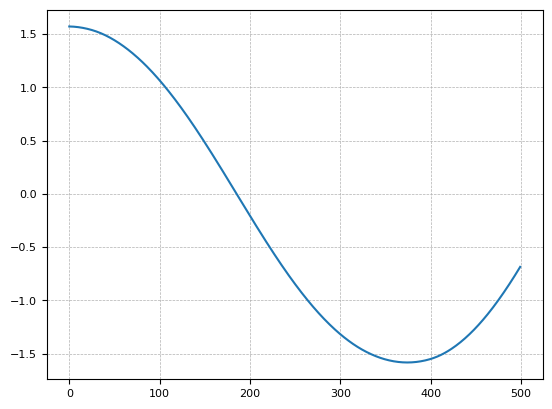

In [5]:
theta_np = utils.common.tensors_to_numpy(
    torch.stack(theta_list).transpose(0, 1)
)  # (bs, n_steps, f_dims)
plt.figure()
plt.plot(theta_np[0, :])